In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import utils


plt.ion()   # interactive mode

ModuleNotFoundError: No module named 'utils'

In [ ]:
cudnn.enabled = True

In [ ]:
cudnn.benchmark = True

In [ ]:
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator

In [ ]:
from torchvision.io import read_image

In [4]:
import torch
import torch.utils.data
from torchvision import models, datasets, tv_tensors
from torchvision.transforms import v2
from torchvision.io import read_image
import trainer as trnr
import engine
import coco_eval
import coco_utils
import tv_utils
from torchvision.utils import draw_bounding_boxes
torch.manual_seed(0)

In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


# obj det test

In [6]:
transforms_ = v2.Compose(
    [
    #v2.ToImage(),
    #v2.RandomResizedCrop(640),
    #v2.RandomPhotometricDistort(),
    #v2.RandomHorizontalFlip(),
    #v2.SanitizeBoundingBoxes(),
    v2.ToDtype(torch.float32, scale=True),
    #v2.ToPureTensor()
    ]
)

In [7]:
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN_ResNet50_FPN_V2_Weights

weights = MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT
transforms = weights.transforms()

In [8]:
# Model class must be defined somewhere
model = torch.load('nav_com3.pt')#.cpu()

In [9]:
img_ = read_image("f15.jpg")

In [10]:
tfm=torchvision.transforms.Resize((640,640))

In [11]:
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [12]:
with torch.no_grad():
    x = transforms(img_)
    x=x.unsqueeze(0).to(device)

In [13]:
img=model(x)

In [14]:
x, img

(tensor([[[[0.4706, 0.4667, 0.4667,  ..., 0.4784, 0.4784, 0.4784],
           [0.4745, 0.4667, 0.4588,  ..., 0.4784, 0.4784, 0.4784],
           [0.4667, 0.4588, 0.4510,  ..., 0.4667, 0.4627, 0.4588],
           ...,
           [0.2588, 0.2510, 0.2549,  ..., 0.3294, 0.3216, 0.3137],
           [0.2588, 0.2510, 0.2510,  ..., 0.3373, 0.3255, 0.3176],
           [0.2588, 0.2510, 0.2510,  ..., 0.3412, 0.3373, 0.3333]],
 
          [[0.4784, 0.4745, 0.4824,  ..., 0.4902, 0.4902, 0.4902],
           [0.4824, 0.4745, 0.4745,  ..., 0.4902, 0.4902, 0.4902],
           [0.4824, 0.4745, 0.4667,  ..., 0.4784, 0.4745, 0.4706],
           ...,
           [0.3098, 0.3020, 0.3059,  ..., 0.3412, 0.3333, 0.3255],
           [0.3098, 0.3020, 0.3020,  ..., 0.3490, 0.3373, 0.3294],
           [0.3098, 0.3020, 0.3020,  ..., 0.3529, 0.3490, 0.3451]],
 
          [[0.5255, 0.5216, 0.5255,  ..., 0.5098, 0.5098, 0.5098],
           [0.5294, 0.5216, 0.5176,  ..., 0.5098, 0.5098, 0.5098],
           [0.5255, 0.51

In [15]:
img_s=next(iter(img))

In [16]:
thresh=img_s['scores'].max()

In [17]:
from torchvision.utils import draw_bounding_boxes
from torchvision.utils import draw_segmentation_masks
from torchvision.ops import masks_to_boxes

In [18]:
#mask=(img_s['masks'] == 0.1534).squeeze(1)
box= (img_s['boxes'] == img_s['scores'].max())

masks = (img_s["masks"] > 0.007).squeeze(1)

In [19]:
img_s['scores']

tensor([0.9696, 0.1351], grad_fn=<IndexBackward0>)

In [20]:
masks.size()

torch.Size([2, 1872, 2936])

In [21]:
tfm(masks).size()

torch.Size([2, 640, 640])

In [22]:
m_viz = draw_segmentation_masks(tfm(img_), tfm(masks), alpha=0.5, colors="red")

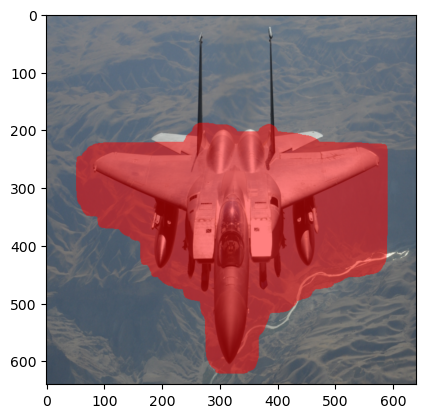

In [23]:
plt.imshow(m_viz.permute(1, 2, 0))

In [24]:
b_viz=draw_bounding_boxes(img_, img_s['boxes'],colors='red')

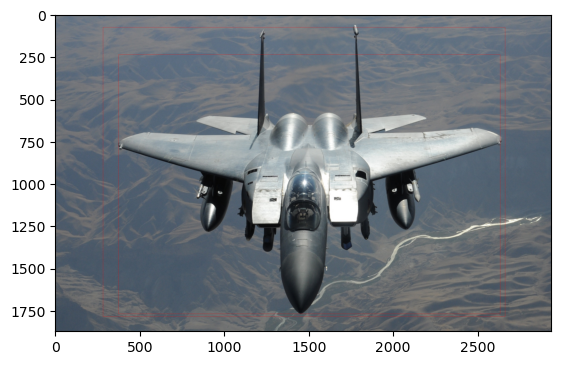

In [25]:
plt.imshow(b_viz.permute(1, 2, 0))

In [19]:
#image = (255.0 * (img_ - img_.min()) / (img_.max() - img_.min())).to(torch.uint8)
#image = image[:3, ...]
pred_labels = [f"F15: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(rs_img, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.007).squeeze(1)

C:\Users\arinz\anaconda3\envs\ai_ml\Lib\site-packages\torchvision\utils.py:209: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")


In [20]:
masks.shape

torch.Size([0, 224, 224])

In [21]:
rs_img.shape

torch.Size([3, 224, 224])

In [22]:
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="red")

C:\Users\arinz\anaconda3\envs\ai_ml\Lib\site-packages\torchvision\utils.py:303: UserWarning: masks doesn't contain any mask. No mask was drawn
  warnings.warn("masks doesn't contain any mask. No mask was drawn")


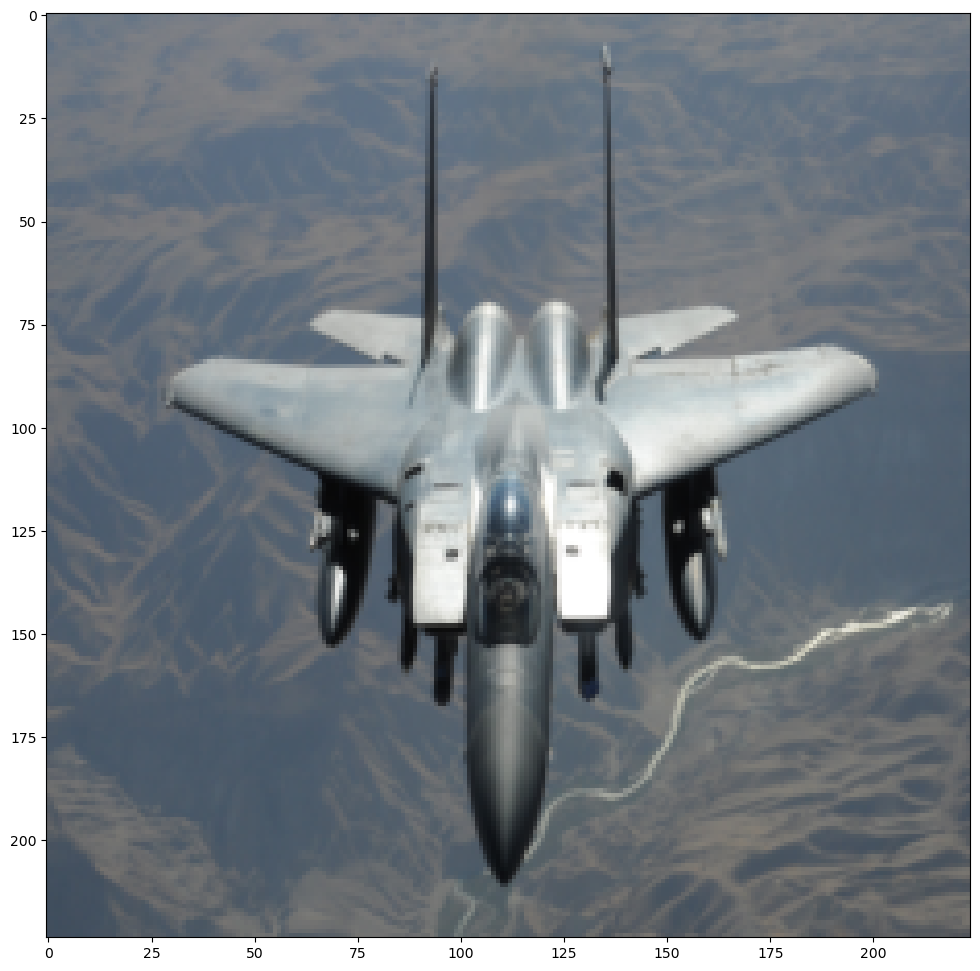

In [23]:
plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

# obj detection / inst segmentation

In [6]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

In [7]:
transforms_ = v2.Compose(
    [
    v2.ToImage(),
    v2.RandomResizedCrop((640), antialias=True),
    v2.RandomPhotometricDistort(),
    #v2.RandomIoUCrop(),
    v2.RandomHorizontalFlip(),
    v2.SanitizeBoundingBoxes(),
    v2.ToDtype(torch.float32, scale=True),
    v2.ToPureTensor()
    ]
)

In [8]:
transforms_

Compose(
      ToImage()
      RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=InterpolationMode.BILINEAR, antialias=True)
      RandomPhotometricDistort(brightness=(0.875, 1.125), contrast=(0.5, 1.5), hue=(-0.05, 0.05), saturation=(0.5, 1.5), p=0.5)
      RandomIoUCrop(min_scale=0.3, max_scale=1.0, min_aspect_ratio=0.5, max_aspect_ratio=2.0, options=[0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0], trials=40)
      RandomHorizontalFlip(p=0.5)
      SanitizeBoundingBoxes(min_size=1.0, labels_getter=default)
      ToDtype(scale=True)
      ToPureTensor()
)

In [9]:
train="train"
train_ann="annotations.coco.json"

In [10]:
val="valid"
val_ann="val_annotations.coco.json"

In [11]:
dataset = datasets.CocoDetection(train,train_ann, transforms=transforms_)
dataset = datasets.wrap_dataset_for_transforms_v2(dataset, target_keys=["segmentation","area","iscrowd","image_id","bbox",
                                                                        "category_id","boxes", "labels", "masks"])

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [12]:
val_ds = datasets.CocoDetection(val,val_ann, transforms=transforms_)
val_ds = datasets.wrap_dataset_for_transforms_v2(val_ds, target_keys=["segmentation","area","iscrowd","image_id","bbox",
                                                                        "category_id","boxes", "labels", "masks"])

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [13]:
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    num_workers=4,
    shuffle=True,
    # We need a custom collation function here, since the object detection
    # models expect a sequence of images and target dictionaries. The default
    # collation function tries to torch.stack() the individual elements,
    # which fails in general for object detection, because the number of bounding
    # boxes varies between the images of the same batch.
    collate_fn= tv_utils.collate_fn #lambda batch: tuple(zip(*batch))
)

In [14]:
val_data_loader = torch.utils.data.DataLoader(
    val_ds,
    batch_size=1,
    num_workers=4,
    shuffle=False,
    # We need a custom collation function here, since the object detection
    # models expect a sequence of images and target dictionaries. The default
    # collation function tries to torch.stack() the individual elements,
    # which fails in general for object detection, because the number of bounding
    # boxes varies between the images of the same batch.
    collate_fn= tv_utils.collate_fn #lambda batch: tuple(zip(*batch))
)

In [15]:
num_classes=5

In [16]:
model = get_model_instance_segmentation(num_classes)
#model = models.get_model("maskrcnn_resnet50_fpn_v2", weights=MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1, weights_backbone="IMAGENET1K_V2")  #.train()

In [17]:
model = model.to(device)

criterion = nn.CrossEntropyLoss()
params = [p for p in model.parameters() if p.requires_grad]
# Observe that all parameters are being optimized
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Decay LR by a factor of 0.1 every 7 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [18]:
for epoch in range(1):
    # train for one epoch, printing every 10 iterations
    engine.train_one_epoch(model,optimizer, data_loader, device, epoch, print_freq=1)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    engine.evaluate(model, val_data_loader, device)

Epoch: [0]  [ 0/34]  eta: 0:44:37  lr: 0.000156  loss: 2.8323 (2.8323)  loss_classifier: 1.6331 (1.6331)  loss_box_reg: 0.0718 (0.0718)  loss_mask: 1.0204 (1.0204)  loss_objectness: 0.0497 (0.0497)  loss_rpn_box_reg: 0.0573 (0.0573)  time: 78.7630  data: 32.3600
Epoch: [0]  [ 1/34]  eta: 0:32:57  lr: 0.000308  loss: 2.8323 (3.0156)  loss_classifier: 1.6331 (1.6365)  loss_box_reg: 0.0503 (0.0611)  loss_mask: 1.0204 (1.2241)  loss_objectness: 0.0497 (0.0512)  loss_rpn_box_reg: 0.0283 (0.0428)  time: 59.9200  data: 16.1800
Epoch: [0]  [ 2/34]  eta: 0:28:11  lr: 0.000459  loss: 2.8323 (2.8939)  loss_classifier: 1.6331 (1.6196)  loss_box_reg: 0.0718 (0.0659)  loss_mask: 1.0204 (1.1362)  loss_objectness: 0.0497 (0.0402)  loss_rpn_box_reg: 0.0283 (0.0319)  time: 52.8461  data: 10.7867
Epoch: [0]  [ 3/34]  eta: 0:24:56  lr: 0.000610  loss: 2.7736 (2.8638)  loss_classifier: 1.5859 (1.5890)  loss_box_reg: 0.0718 (0.0826)  loss_mask: 1.0204 (1.1290)  loss_objectness: 0.0311 (0.0379)  loss_rpn_box

In [19]:
torch.save(model,'nav_com2.pt')

# img classification

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
data_="data/aero_nav_combat"

In [5]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_, x),data_transforms[x]) for x in ['train', 'val']}

In [6]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,shuffle=True, num_workers=4)for x in ['train', 'val']}

In [7]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [8]:
class_names = image_datasets['train'].classes

In [9]:
class_names

['apache',
 'bfv',
 'f15',
 'f22',
 'f35',
 'fa18',
 'hmv',
 'm1',
 'stryker',
 'uss_rr']

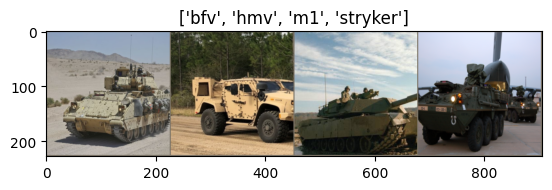

In [10]:
# test
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [12]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [13]:
model_ft = models.resnet50(weights='IMAGENET1K_V2')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [14]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=21)

Epoch 0/20
----------
train Loss: 1.8960 Acc: 0.3855
val Loss: 1.1976 Acc: 0.6694

Epoch 1/20
----------
train Loss: 1.0817 Acc: 0.6299
val Loss: 0.6322 Acc: 0.7851

Epoch 2/20
----------
train Loss: 0.7541 Acc: 0.7291
val Loss: 0.5160 Acc: 0.8388

Epoch 3/20
----------
train Loss: 0.6362 Acc: 0.7961
val Loss: 0.4201 Acc: 0.8636

Epoch 4/20
----------
train Loss: 0.5433 Acc: 0.8212
val Loss: 0.3958 Acc: 0.8843

Epoch 5/20
----------
train Loss: 0.4604 Acc: 0.8436
val Loss: 0.3368 Acc: 0.8967

Epoch 6/20
----------
train Loss: 0.4221 Acc: 0.8673
val Loss: 0.3396 Acc: 0.8967

Epoch 7/20
----------
train Loss: 0.3690 Acc: 0.8883
val Loss: 0.3415 Acc: 0.9008

Epoch 8/20
----------
train Loss: 0.3183 Acc: 0.9022
val Loss: 0.3220 Acc: 0.9050

Epoch 9/20
----------
train Loss: 0.3544 Acc: 0.8841
val Loss: 0.3265 Acc: 0.9091

Epoch 10/20
----------
train Loss: 0.3136 Acc: 0.9106
val Loss: 0.3250 Acc: 0.9132

Epoch 11/20
----------
train Loss: 0.3305 Acc: 0.8980
val Loss: 0.3228 Acc: 0.9050

Ep

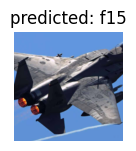

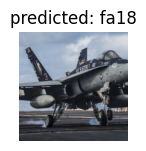

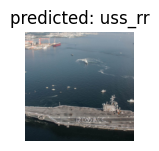

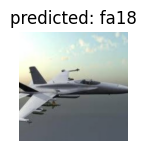

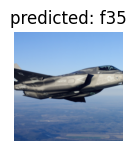

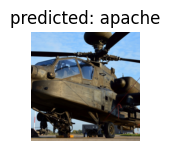

In [15]:
visualize_model(model_ft)

In [16]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

In [18]:
torch.save(model_ft,'combat_vehicles.pt')

In [23]:
visualize_model_predictions(model_ft,img_path='data\aero_nav_combat\val\f15\f16.jpg')

plt.ioff()
plt.show()

OSError: [Errno 22] Invalid argument: 'C:\\Users\\arinz\\Documents\\code\\images\\data\x07ero_nav_combat\x0bal\x0c15\x0c16.jpg'